In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [108]:
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world
mesh_path = "/home/julian/uni/ushichka-registration/data/formatted/lidar_roi.ply"
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
pvMesh = pv.read(mesh_path)

0.9999999999999996
[[   -378.23    -430.27     225.58    2060.11]
 [    172.31    -486.37    -275.62    1380.59]
 [      0.34      -0.74       0.58       5.01]]
0.9999999999999998


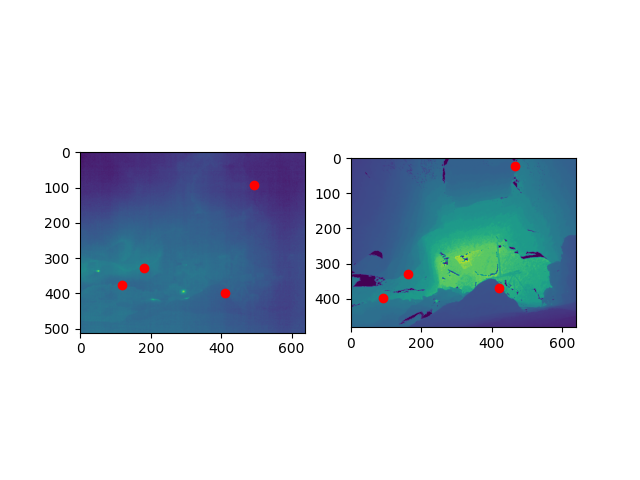

In [109]:
exp = Experiment( "/data/dmcp_experiments/round_05/2018-08-17--cam1", mesh_path)
#exp = Experiment( "/data/dmcp_experiments/round_04/2018-08-17--cam1", mesh_path)
#exp = Experiment( "/data/dmcp_experiments/dmcp_original", mesh_path)

imIm = exp.load_imIm()
imK = exp.load_imK()
imP = exp.load_imP()

dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()

cps = exp.load_cps()
pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])

trans = exp.load_transform()

def dt(K,P):
    ext = la.inv(K) @ P
    dt = la.det(ext[:3,:3])
    return dt

print(dt(imK,imP))
print(imP)

print(dt(dmK,dmP))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r")
plt.show()

In [110]:
exp.visualize_3D()

[      2.35      -1.35      -1.40]


In [111]:
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts_world))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

# transform all cameras in scene

In [112]:
from src.pyushichka import loadCalibration

ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(trans)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

In [113]:
from src.pycv.dmcp import dmcp as dmcp
RP, A = dmcp(imK, imP, cps[:,:2], pts_world, return_raw_pose=True)
ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(A)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)
pts = np.array(pts)

plotter = pv.Plotter(notebook=False)
sporig = pv.Sphere(radius=0.5, center=RP[:3,-1])
posM = pv.PolyData(np.array(pts))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.add_mesh(sporig,color="green")
plotter.show()


estimated pose
[[      0.46      -0.30      -0.84       2.35]
 [      0.89       0.15       0.43      -1.35]
 [     -0.01      -0.94       0.34      -1.40]]
scale factor 1.0000000000000002
0.9999999999997571


# calibration space to camera space

In [114]:
ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")] ;
pts = []
for cam in ps:
    K, P = cam
    pos = (la.null_space(P) / la.null_space(P)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
pts_hat = np.hstack((pts, np.ones((pts.shape[0],1))))
pts_hat

array([[     -2.80,       1.97,      -0.31,       1.00],
       [     -0.93,       4.12,      -2.84,       1.00],
       [      0.64,       4.10,      -1.40,       1.00]])

In [115]:
K, P = loadCalibration(1,r"C:\data\ushichka\2018-08-17")
extr1 = (la.inv(K) @ P)#[:3,:] # maps world to camera coordinates
#extr1 = (np.array([[1,0,0],[0,-1,0],[0,0,1]]) @ extr1)

pts_camera = extr1 @ pts_hat.T
pts_camera.T

#(np.array([[1,0,0],[0,-1,0],[0,0,1]]) @ pts_camera).T

array([[      2.71,      -1.13,       2.42],
       [     -0.00,       0.00,       0.00],
       [     -1.34,      -0.89,       1.39]])

## World space to camera space

using thesis result

In [116]:
pts = np.array([[1.74, 2.02,0.4669],[2.04,-1.34,-1.6],[0.48,-2.1,-0.22]])
pts

pts_hat = np.hstack((pts, np.ones((pts.shape[0],1))))

pts_hat

array([[      1.74,       2.02,       0.47,       1.00],
       [      2.04,      -1.34,      -1.60,       1.00],
       [      0.48,      -2.10,      -0.22,       1.00]])

In [117]:
pose_matrix = RP.copy()
extrinsic_matrix = la.inv(np.vstack((pose_matrix,[0,0,0,1])))
#shifter = np.eye(4)
#shifter[1,:] = -1*shifter[1,:]
#extrinsic_matrix = (shifter @ extrinsic_matrix)[:3,:]
extrinsic_matrix

(extrinsic_matrix @ pts_hat.T).T

array([[      2.69,      -1.08,       2.60,       1.00],
       [     -0.13,       0.29,       0.19,       1.00],
       [     -1.54,      -0.65,       1.63,       1.00]])

using alignment result

In [120]:
ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(A)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)
pts = np.array(pts)
pts_hat = np.hstack((pts, np.ones((pts.shape[0],1))))

pts_hat

array([[      1.92,       1.95,       0.46,       1.00],
       [      2.35,      -1.35,      -1.40,       1.00],
       [      0.85,      -2.07,      -0.07,       1.00]])

In [121]:
pose_matrix = RP.copy()
extrinsic_matrix = la.inv(np.vstack((pose_matrix,[0,0,0,1])))
#shifter = np.eye(4)
#shifter[1,:] = -1*shifter[1,:]
#extrinsic_matrix = (shifter @ extrinsic_matrix)[:3,:]
extrinsic_matrix

(extrinsic_matrix @ pts_hat.T).T

array([[      2.71,      -1.13,       2.42,       1.00],
       [      0.00,       0.00,       0.00,       1.00],
       [     -1.34,      -0.89,       1.39,       1.00]])